# IMPORTS & CONFIGS 

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import glob
from scipy import signal
from scipy.stats import norm
from scipy.optimize import curve_fit
import re
from scipy.fft import fft, ifft

# DATA PROCESSING FUNCTIONS

In [16]:
def data_start(dir: str) -> object:
    df = pd.read_csv(dir, sep=';',decimal='.', index_col=False, skiprows=10, usecols=range(4), encoding='iso-8859-1')
    df['datetime'] = pd.to_datetime(df.iloc[:, 0])
    # Drop the original date and time columns by index
    df.drop(df.columns[[0]], axis=1, inplace=True)
    df.replace(-9999, np.nan, inplace=True)
    df = df.dropna()
    
    df['year_month'] = df['datetime'].dt.to_period('M')
    df.drop(df.columns[[-2]], axis=1, inplace=True)
    target_columns = ['PRECIPITACAO TOTAL, DIARIO (AUT)(mm)', 'TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)', 'UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)']

    df[target_columns] = df[target_columns].map(
        lambda x: re.sub(r'^\.(\d+)', r'0.\1', x) if isinstance(x, str) else x
    ).astype(float)
    
    monthly_avg = df.groupby('year_month').mean(numeric_only=True)
    monthly_avg.reset_index(inplace=True)

    del df
    monthly_avg['year_month'] = monthly_avg['year_month'].dt.to_timestamp() 
    return monthly_avg.sort_values("year_month")

In [17]:
def plot(df: object) -> None:
    plt.figure(figsize=(10, 5))

    # Plot the 'x' column
    for i in df.columns:
        if i != 'year_month':
            plt.plot(df['year_month'], df[i], linestyle='-', label=i)  

    # Adding titles and labels
    # plt.title('Data x Months')
    plt.xlabel('DATA')
    plt.ylabel('YEAR_MOUNTH')

    # Adding a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

In [18]:
def plot_fft(data, column_name):
    # Calculate the FFT
    
    # Assuming 'signal' is your original signal
    mean_signal = np.mean(data[column_name])
    normalized_signal = data[column_name]/data[column_name].max()
    
    fft_result = fft(data[column_name])

    # Calculate the frequency axis in days
    freq = np.fft.fftfreq(len(fft_result), 12)  # Assuming daily sampling

    # Plot the FFT with time in days on the x-axis
    plt.figure(figsize=(10, 6))
    plt.plot(freq, np.abs(fft_result))
    plt.xlabel('Time (days)')
    plt.ylabel('FFT Magnitude')
    plt.title(f'FFT of DataFrame {column_name}')
    plt.grid(True)
    plt.show()
    
    # Calculate the inverse FFT
    ifft_result = ifft(fft_result)

    # Plot the inverse FFT
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, ifft_result)
    plt.xlabel('Time (days)')
    plt.ylabel('Inverse FFT')
    # plt.title(f'Inverse FFT of DataFrame {column_name}')
    plt.grid(True)
    plt.show()

In [19]:
def fft_process(dataframes):
    for i, df in dataframes.items():
        # print(f"Processing DataFrame {i}/{len(dataframes)}")
        for column in df.columns:
            if column == 'year_month':
                continue
            print(f"Plotting FFT for column: {column} from {i}")
            

            plot_fft(df, column)


In [20]:
def apply_convolution(x, window):
    window = len(x)/10
    conv = np.repeat([0., 1., 0.], window)
    filtered = signal.convolve(x, conv, mode='same') / window
    return filtered

# MAIN

dados_A001_D_2000-05-06_2024-05-26


year_month                                       2024-05-01 00:00:00
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                           19.15
TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)                       25.454839
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)              86.267742
dtype: object

year_month                                       2000-05-01 00:00:00
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                             0.0
TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)                       17.622581
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)                  35.64
dtype: object

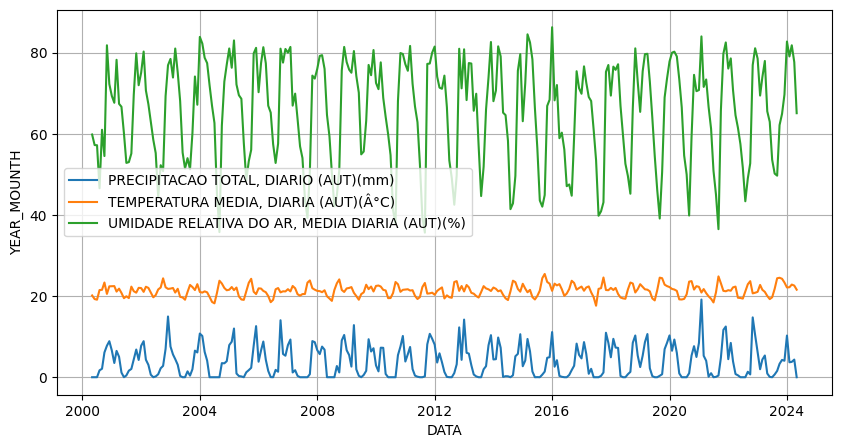

dados_A008_D_2003-06-12_2013-02-19


year_month                                       2013-02-01 00:00:00
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                        19.43871
TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)                       24.778571
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)              84.417857
dtype: object

year_month                                       2003-06-01 00:00:00
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                             0.0
TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)                            18.4
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)              34.896667
dtype: object

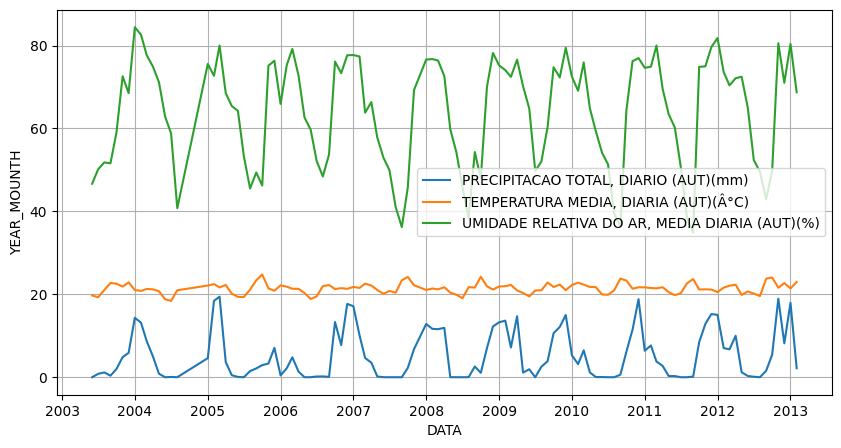

dados_A042_D_2017-07-18_2024-05-26


year_month                                       2024-05-01 00:00:00
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                          23.112
TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)                       25.386667
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)                 85.276
dtype: object

year_month                                       2017-07-01 00:00:00
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                             0.0
TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)                       18.427273
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)              34.923333
dtype: object

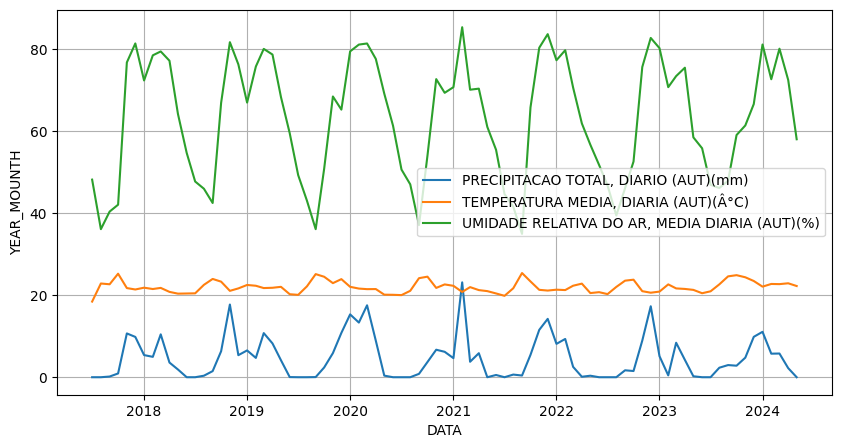

dados_A045_D_2008-10-02_2024-05-26


year_month                                       2024-05-01 00:00:00
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                       16.053333
TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)                       24.709677
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)              85.051613
dtype: object

year_month                                       2008-10-01 00:00:00
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                             0.0
TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)                       17.545161
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)                  39.69
dtype: object

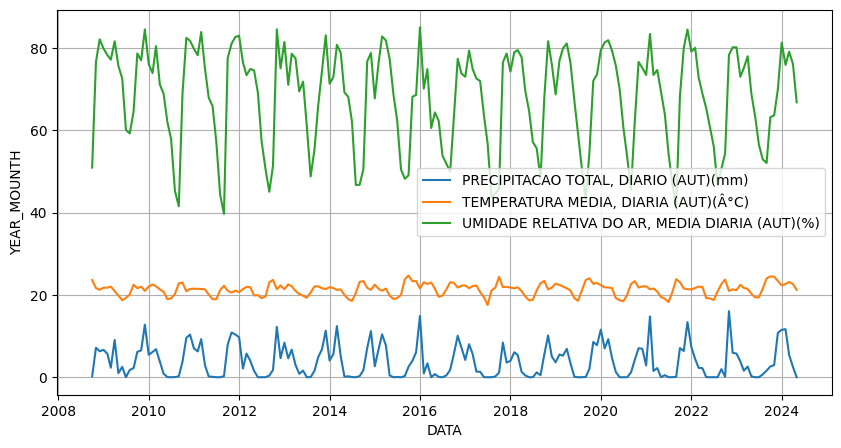

dados_A046_D_2014-09-30_2024-05-26


year_month                                       2024-05-01 00:00:00
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                       15.635714
TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)                       25.848387
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)              81.427586
dtype: object

year_month                                       2014-10-01 00:00:00
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                             0.0
TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)                       17.790323
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)              35.193333
dtype: object

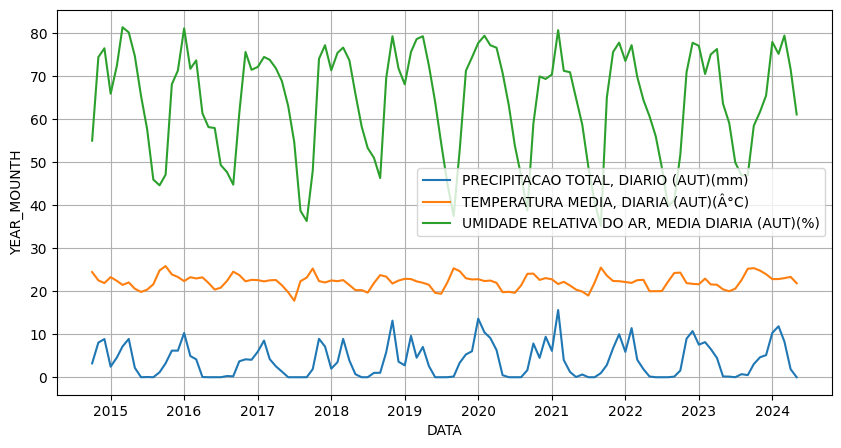

dados_A047_D_2017-02-06_2024-05-26


year_month                                       2024-05-01 00:00:00
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                       21.992857
TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)                       25.106667
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)              88.067857
dtype: object

year_month                                       2017-02-01 00:00:00
PRECIPITACAO TOTAL, DIARIO (AUT)(mm)                             0.0
TEMPERATURA MEDIA, DIARIA (AUT)(Â°C)                       17.219355
UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)              39.953333
dtype: object

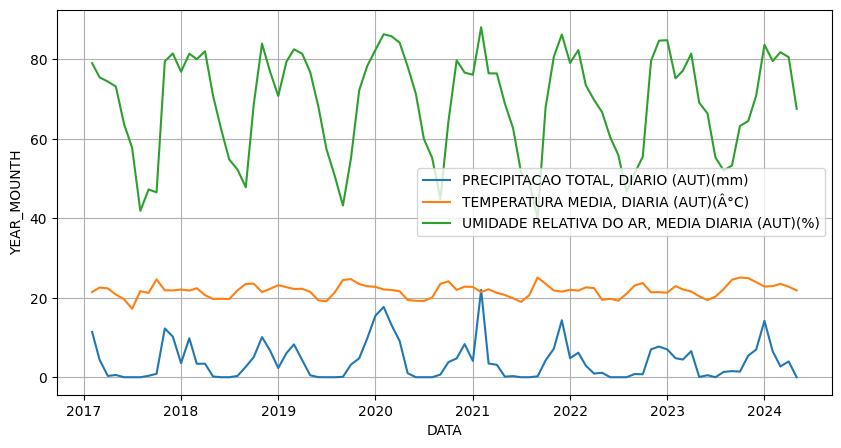

Plotting FFT for column: PRECIPITACAO TOTAL, DIARIO (AUT)(mm) from dados_A001_D_2000-05-06_2024-05-26


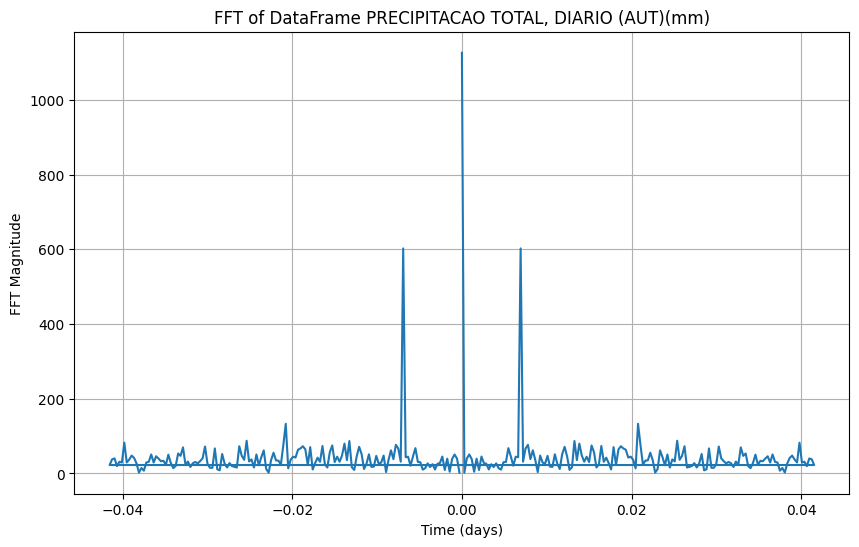

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


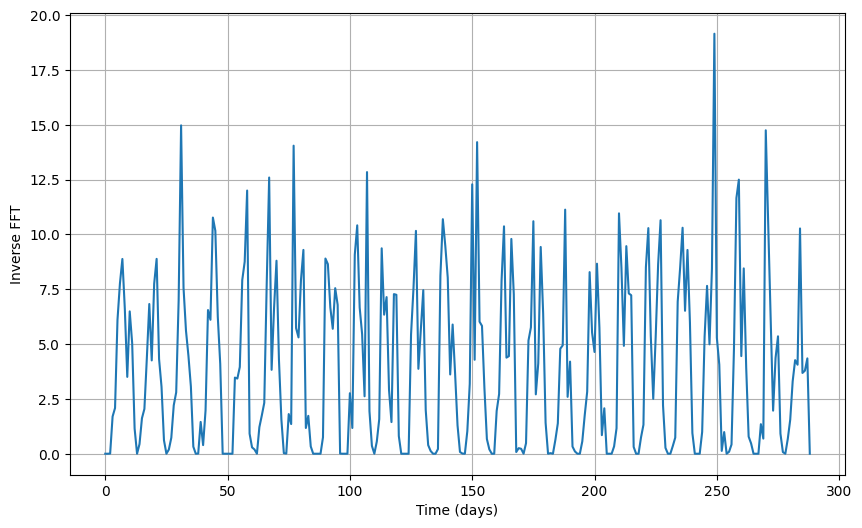

Plotting FFT for column: TEMPERATURA MEDIA, DIARIA (AUT)(Â°C) from dados_A001_D_2000-05-06_2024-05-26


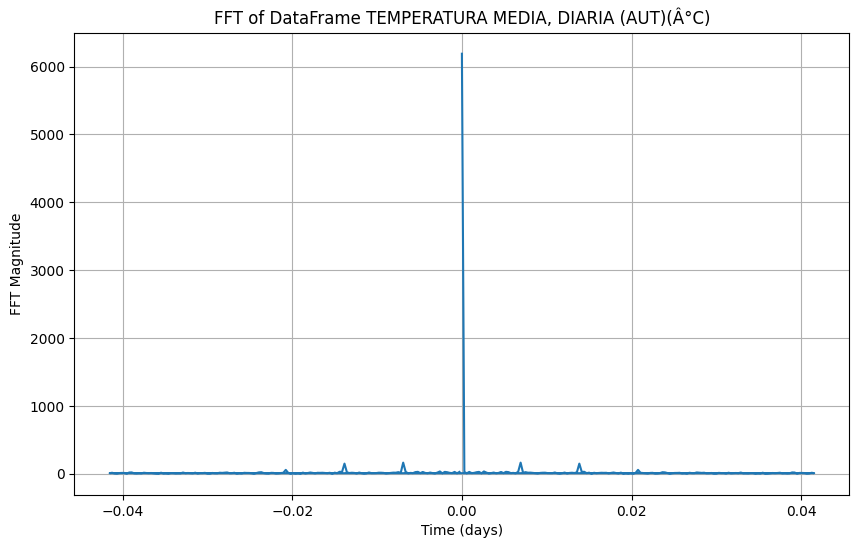

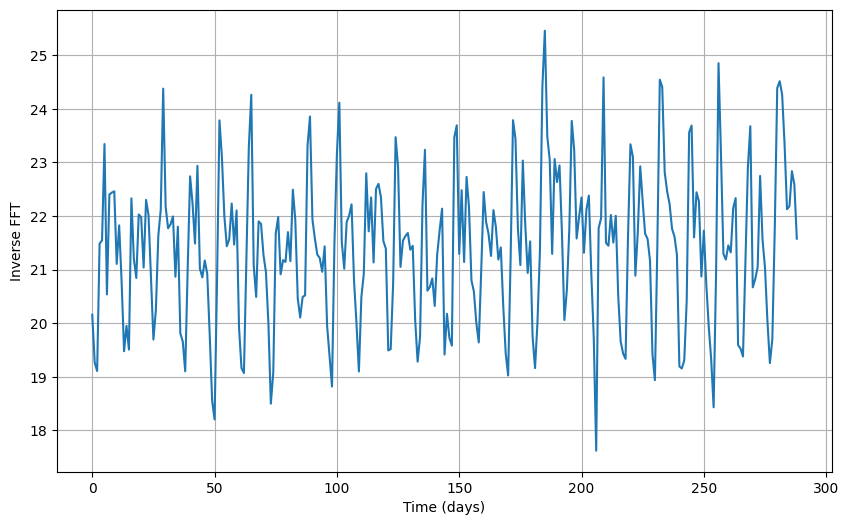

Plotting FFT for column: UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%) from dados_A001_D_2000-05-06_2024-05-26


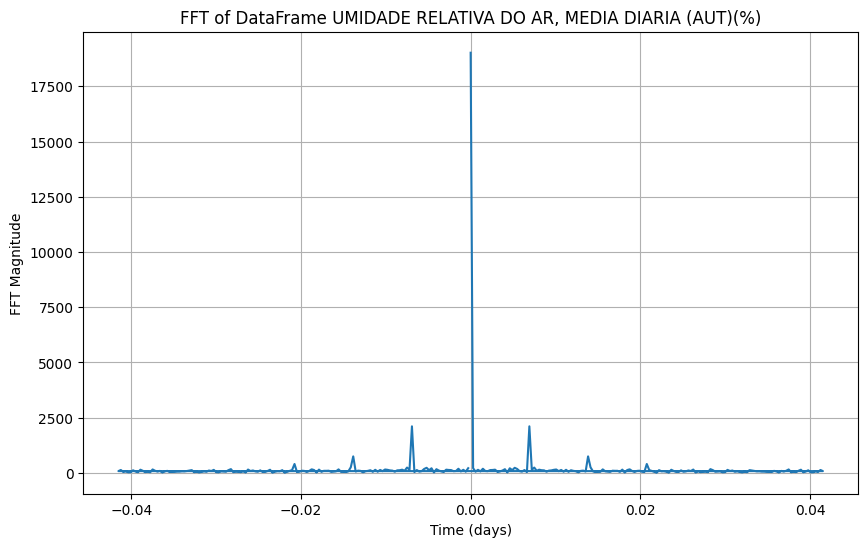

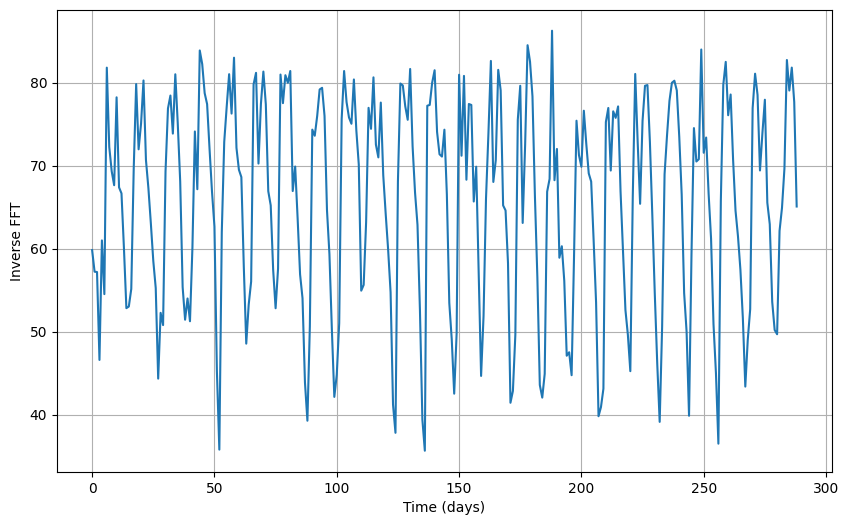

Plotting FFT for column: PRECIPITACAO TOTAL, DIARIO (AUT)(mm) from dados_A008_D_2003-06-12_2013-02-19


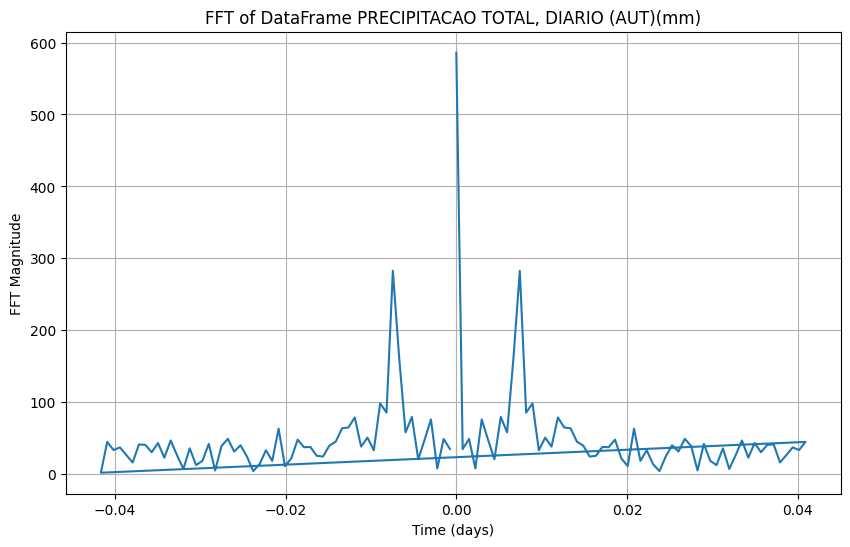

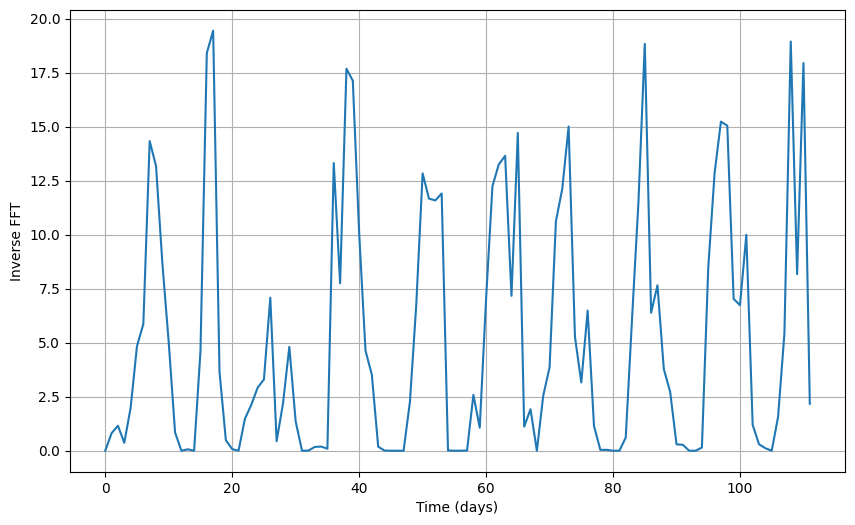

Plotting FFT for column: TEMPERATURA MEDIA, DIARIA (AUT)(Â°C) from dados_A008_D_2003-06-12_2013-02-19


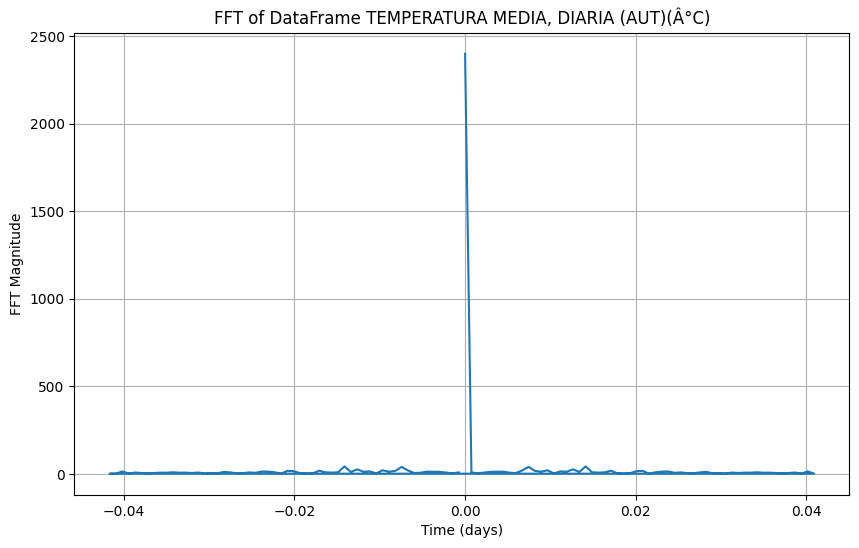

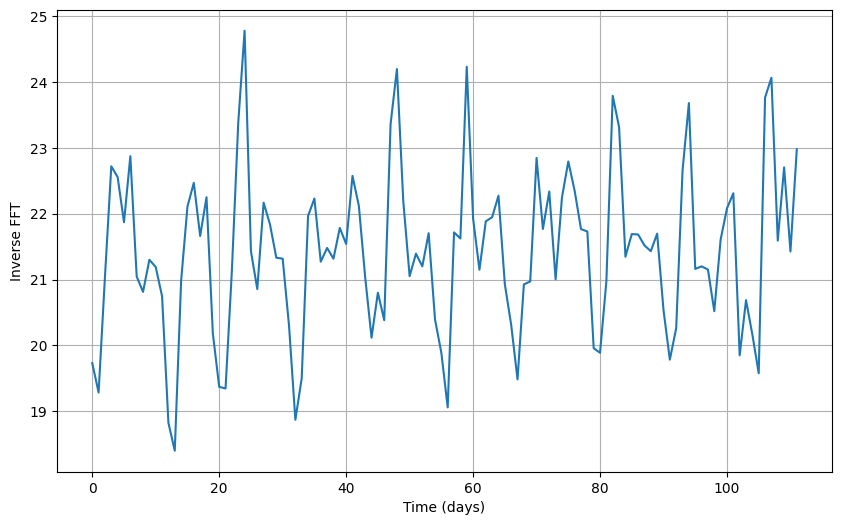

Plotting FFT for column: UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%) from dados_A008_D_2003-06-12_2013-02-19


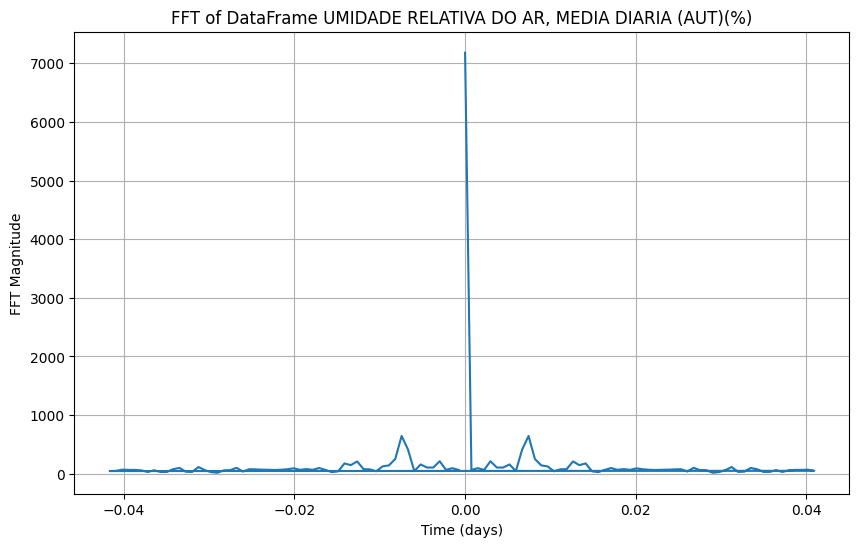

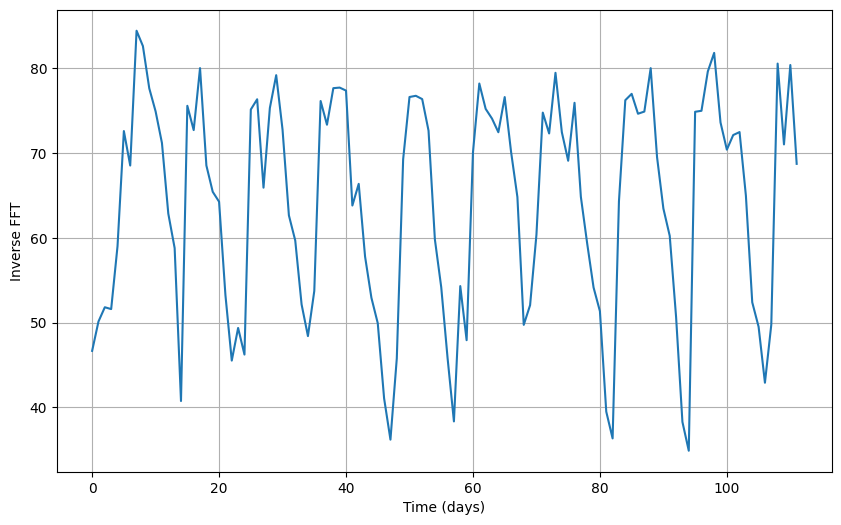

Plotting FFT for column: PRECIPITACAO TOTAL, DIARIO (AUT)(mm) from dados_A042_D_2017-07-18_2024-05-26


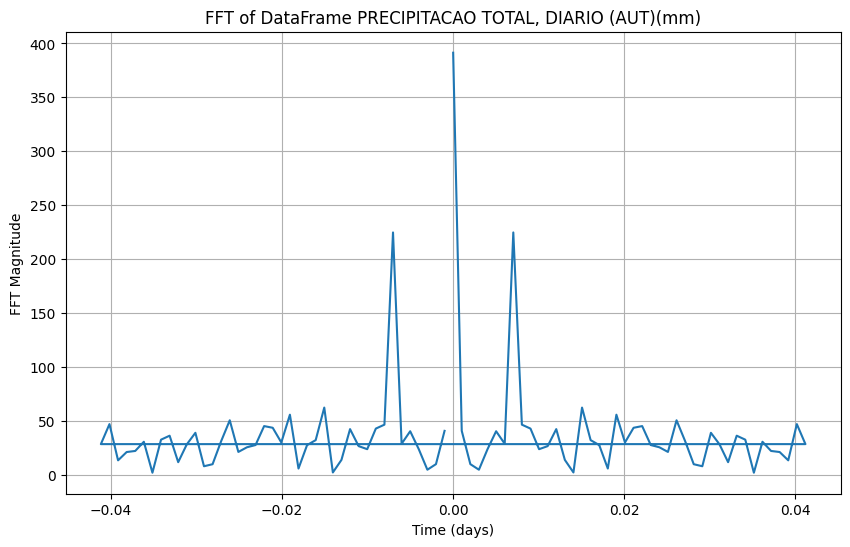

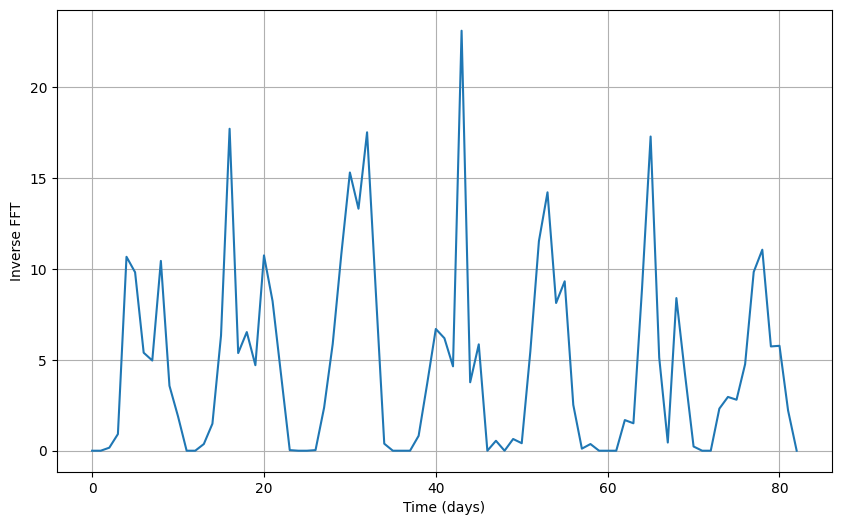

Plotting FFT for column: TEMPERATURA MEDIA, DIARIA (AUT)(Â°C) from dados_A042_D_2017-07-18_2024-05-26


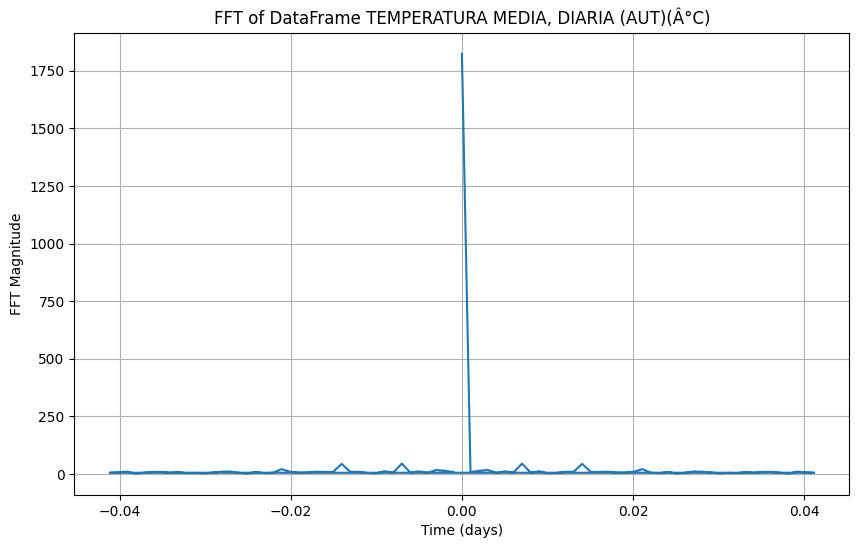

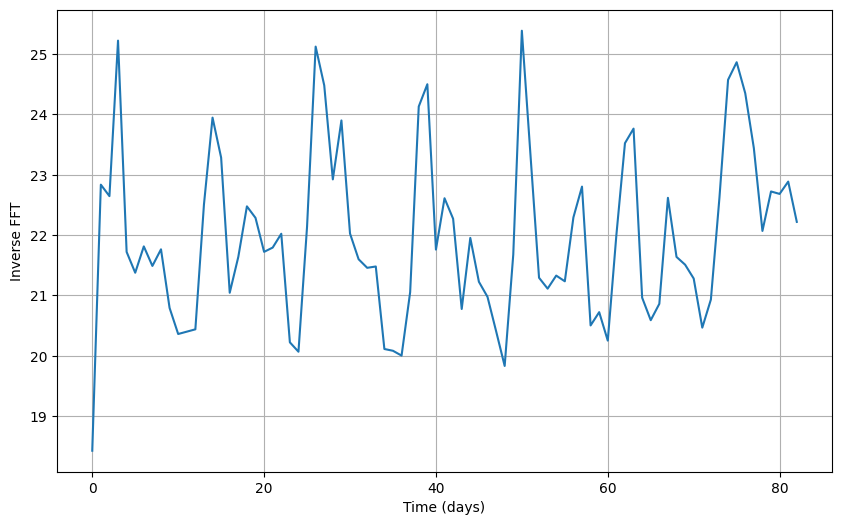

Plotting FFT for column: UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%) from dados_A042_D_2017-07-18_2024-05-26


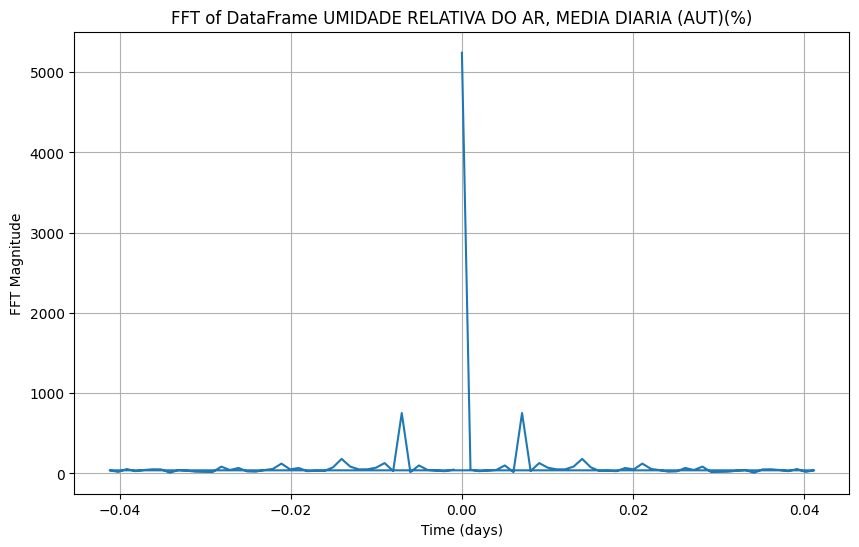

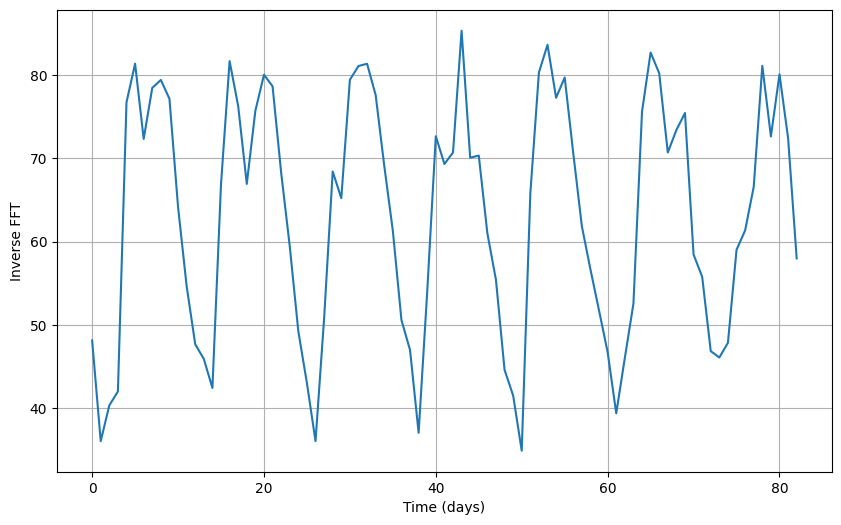

Plotting FFT for column: PRECIPITACAO TOTAL, DIARIO (AUT)(mm) from dados_A045_D_2008-10-02_2024-05-26


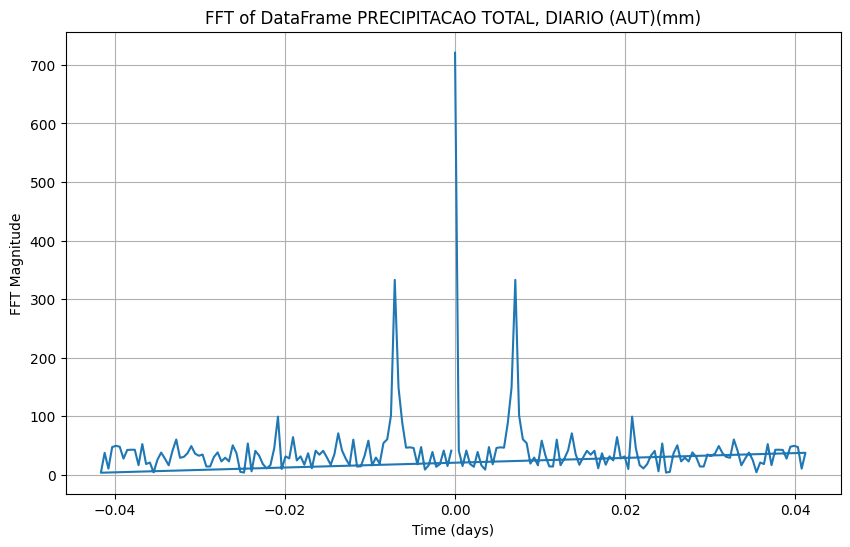

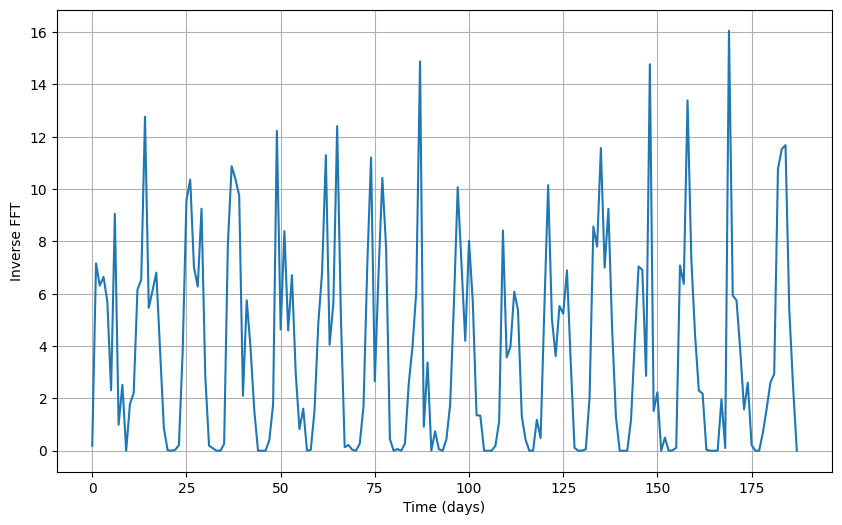

Plotting FFT for column: TEMPERATURA MEDIA, DIARIA (AUT)(Â°C) from dados_A045_D_2008-10-02_2024-05-26


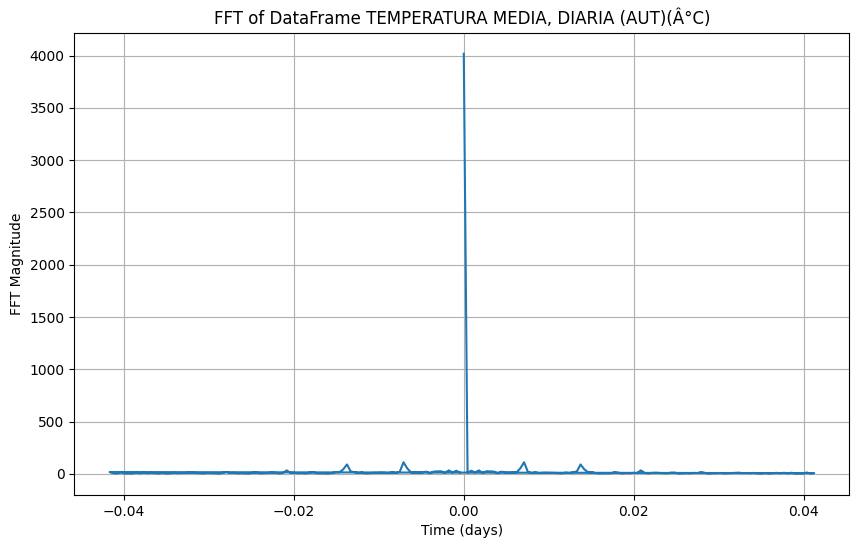

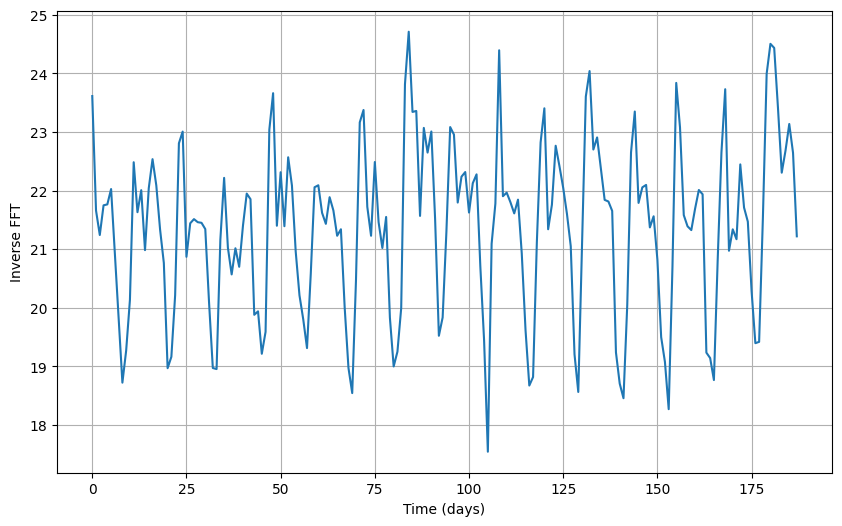

Plotting FFT for column: UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%) from dados_A045_D_2008-10-02_2024-05-26


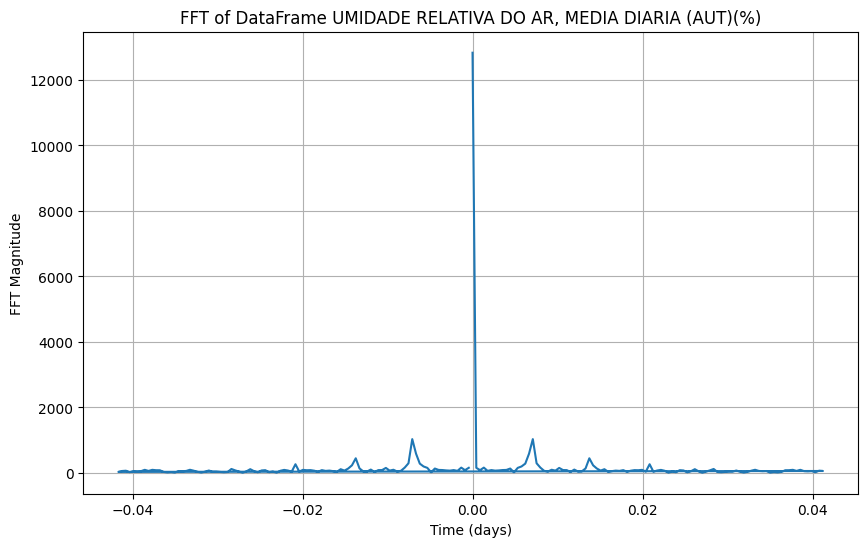

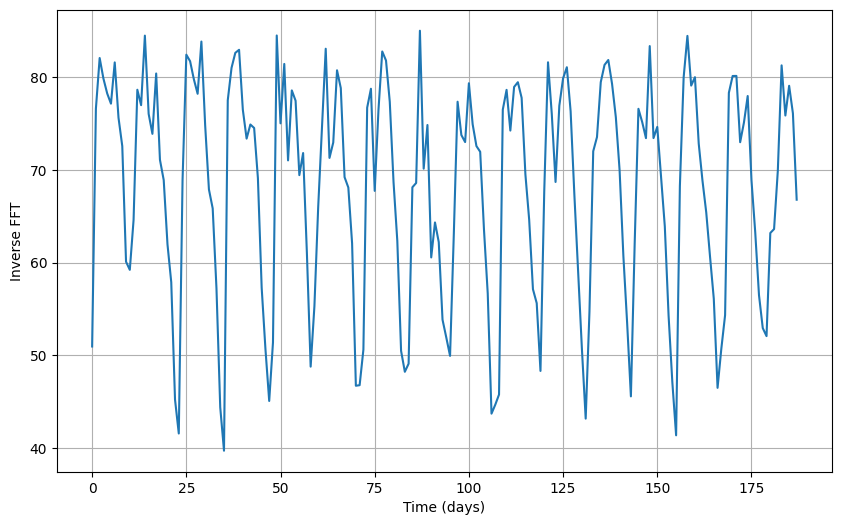

Plotting FFT for column: PRECIPITACAO TOTAL, DIARIO (AUT)(mm) from dados_A046_D_2014-09-30_2024-05-26


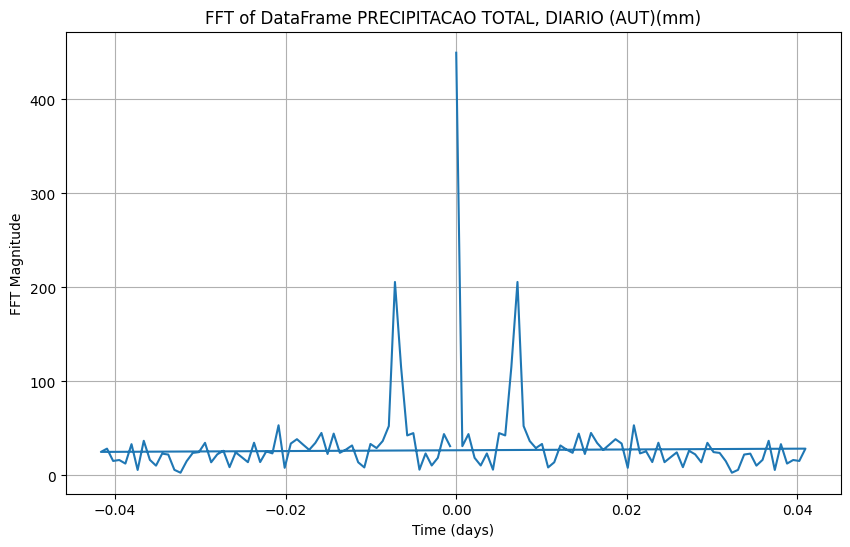

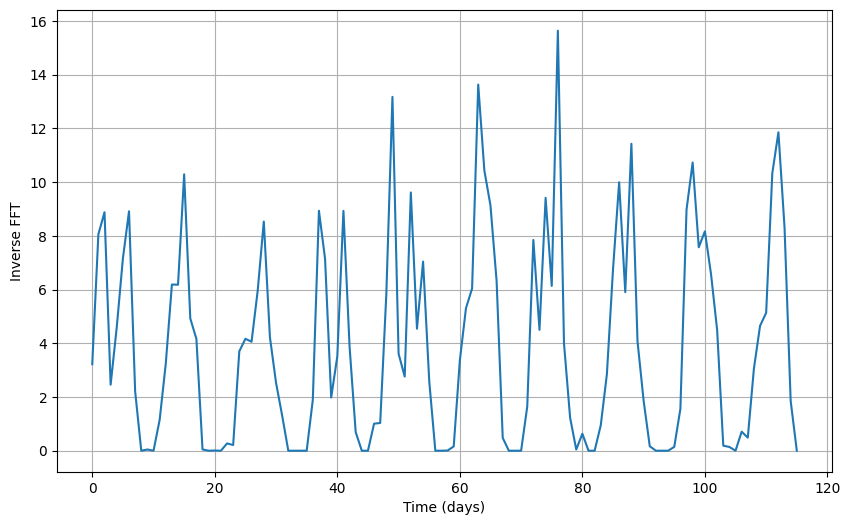

Plotting FFT for column: TEMPERATURA MEDIA, DIARIA (AUT)(Â°C) from dados_A046_D_2014-09-30_2024-05-26


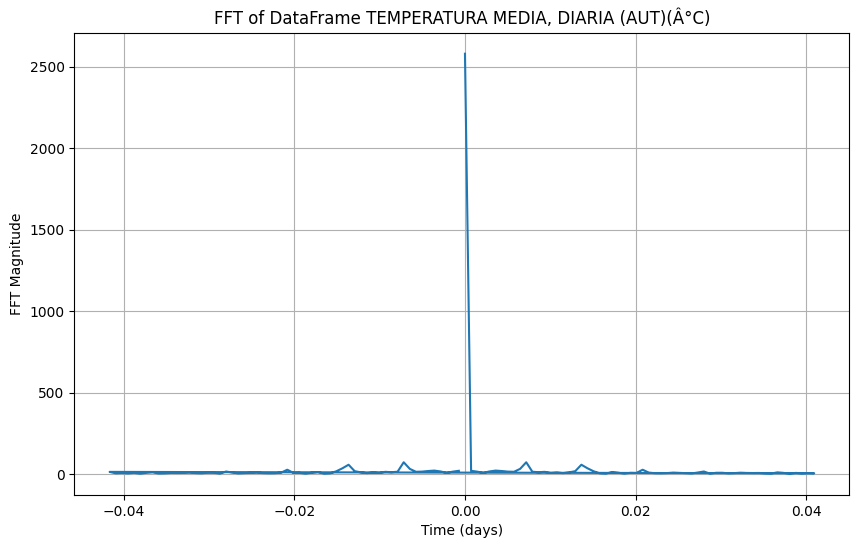

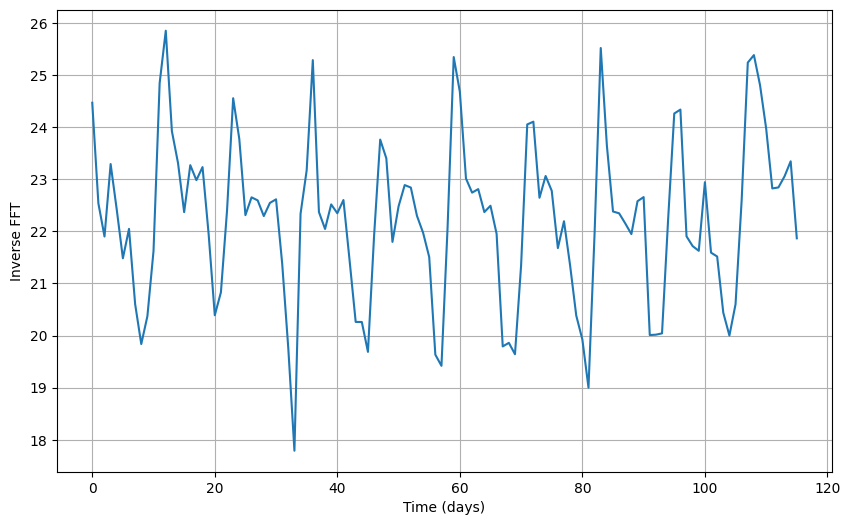

Plotting FFT for column: UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%) from dados_A046_D_2014-09-30_2024-05-26


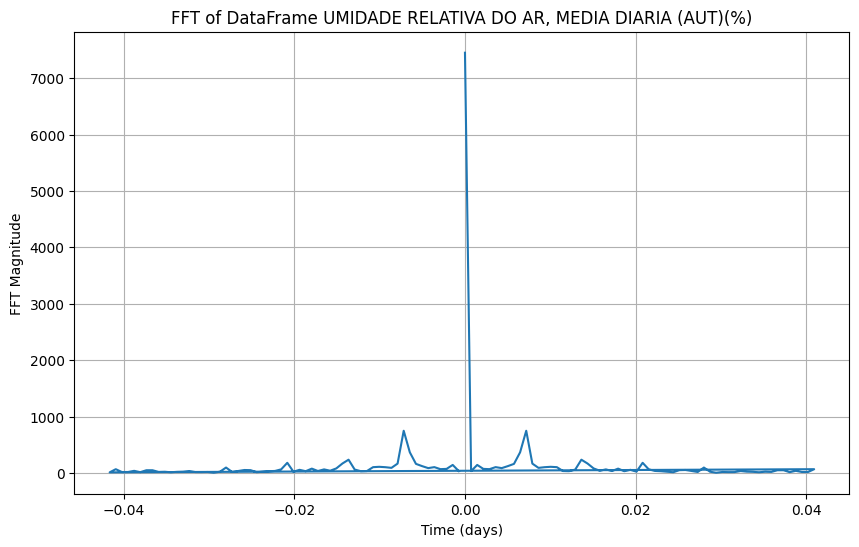

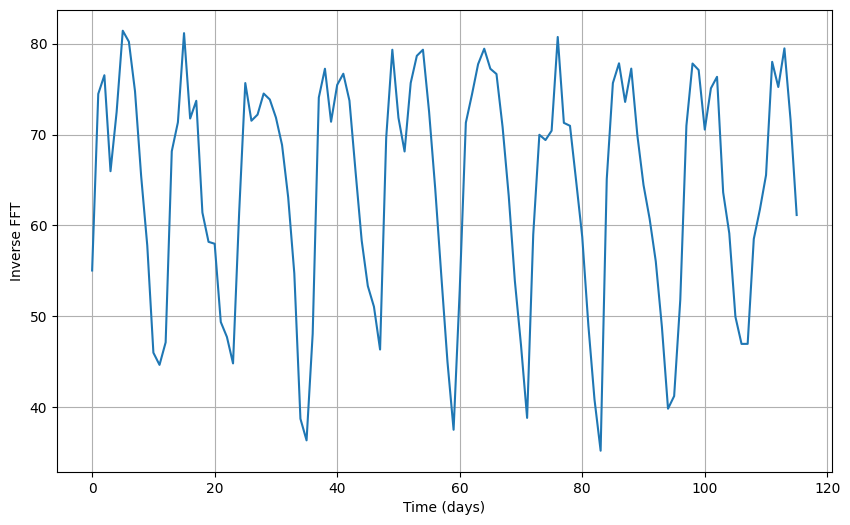

Plotting FFT for column: PRECIPITACAO TOTAL, DIARIO (AUT)(mm) from dados_A047_D_2017-02-06_2024-05-26


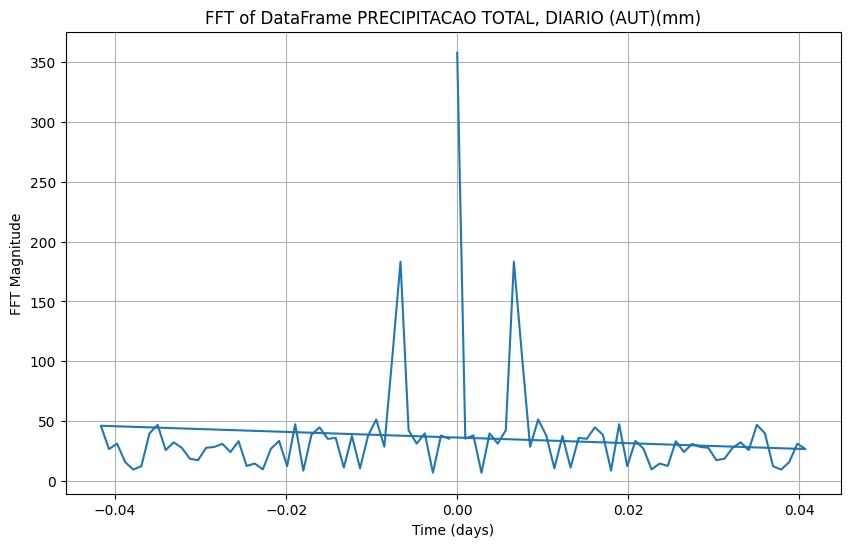

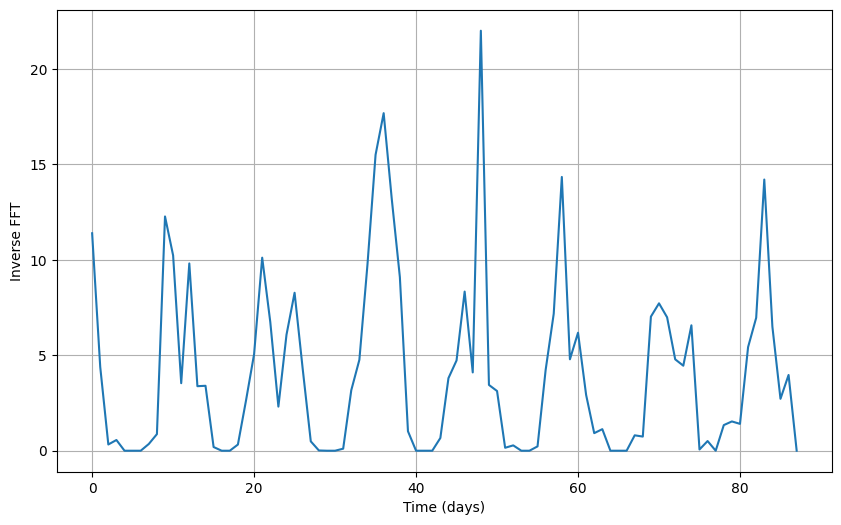

Plotting FFT for column: TEMPERATURA MEDIA, DIARIA (AUT)(Â°C) from dados_A047_D_2017-02-06_2024-05-26


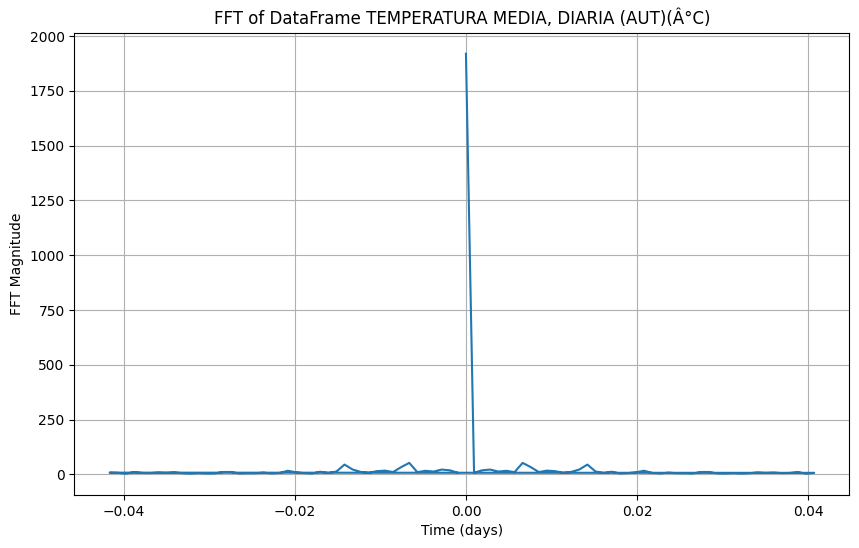

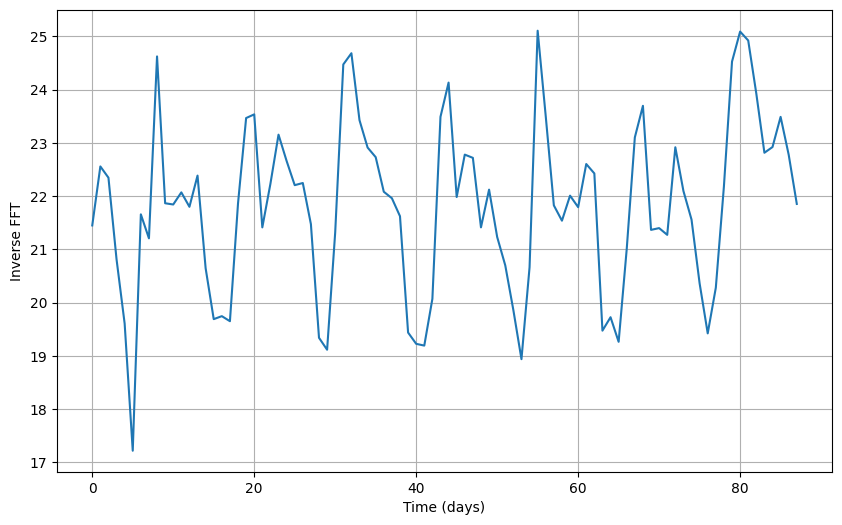

Plotting FFT for column: UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%) from dados_A047_D_2017-02-06_2024-05-26


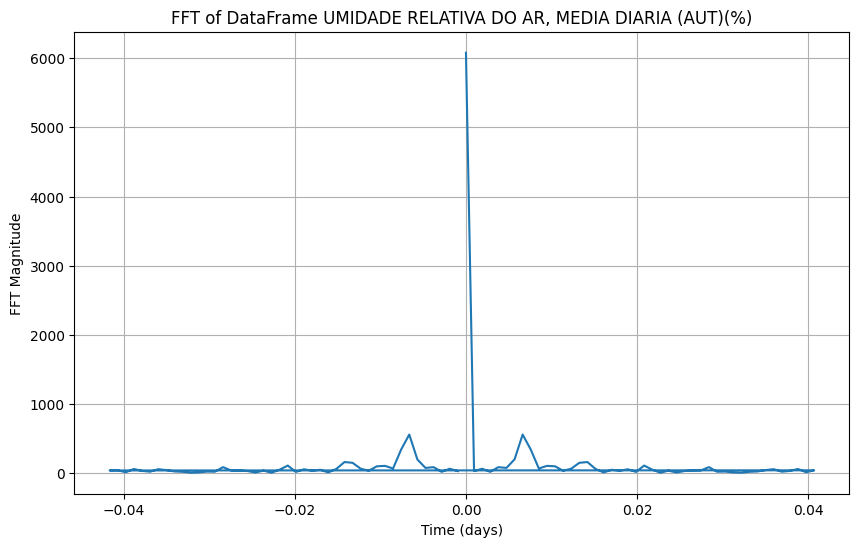

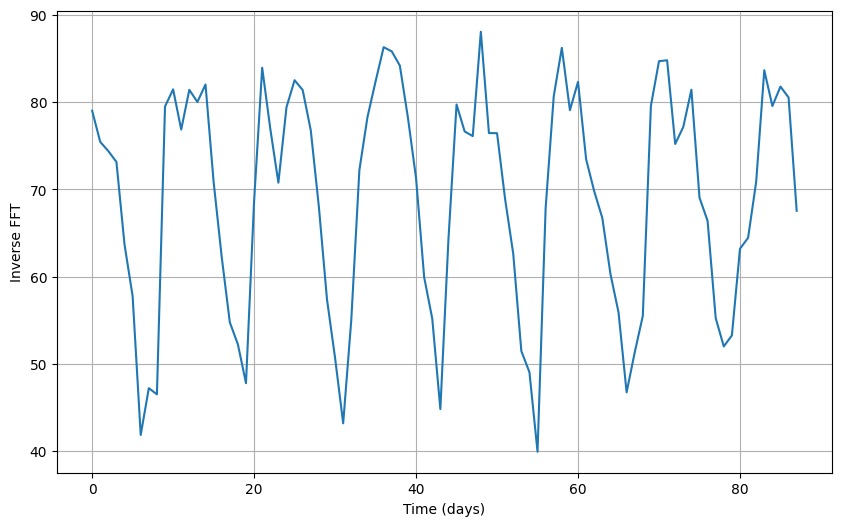

In [21]:
data_dir = "../Data/Auto"
filepaths = glob.glob(os.path.join(data_dir, "*.csv"))
stations = {}
for file in filepaths: 
    # if 'A008' in file: #SKIP A008 STATION BE COUSE ARE NOT IN OPPERATION SINCE 2013
    #     continue 
    stations[file.replace('../Data/Auto\\', '').replace('.csv', '')] = data_start(file)
    
    
for key, value in stations.items():
    print(key)
    display(value.max(), value.min())
    plot(value)

fft_process(stations)